## Importing Required Packages

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

## Downloading the Dataset

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = keras.utils.get_file(fname="stackoverflow", origin=url, untar=True, cache_dir=".", cache_subdir="")

6053168/6053168 [==============================] - 0s 0us/step


## Organizing Files in Train, Validation and Test Directories

In [3]:
train_dir = "./train"
test_dir = "./test"

In [4]:
validation_dir = "./validation"
os.mkdir(validation_dir)
validation_csharp_dir = os.path.join(validation_dir, "csharp")
os.mkdir(validation_csharp_dir)
validation_java_dir = os.path.join(validation_dir, "java")
os.mkdir(validation_java_dir)
validation_javascript_dir = os.path.join(validation_dir, "javascript")
os.mkdir(validation_javascript_dir)
validation_python_dir = os.path.join(validation_dir, "python")
os.mkdir(validation_python_dir)
files = [f"{i}.txt" for i in range(1000)]
for file in files:
  src = os.path.join(test_dir, "csharp", file)
  dst = os.path.join(validation_csharp_dir, file)
  shutil.move(src, dst)
for file in files:
  src = os.path.join(test_dir, "java", file)
  dst = os.path.join(validation_java_dir, file)
  shutil.move(src, dst)
for file in files:
  src = os.path.join(test_dir, "javascript", file)
  dst = os.path.join(validation_javascript_dir, file)
  shutil.move(src, dst)
for file in files:
  src = os.path.join(test_dir, "python", file)
  dst = os.path.join(validation_python_dir, file)
  shutil.move(src, dst)

In [5]:
!rm README.md stackoverflow.tar.gz

## Opening a Sample File

In [6]:
sample_file = os.path.join(test_dir, "javascript", "1564.txt")
with open(sample_file, mode="r+") as file:
  a = file.read()
a

'"using a variable from a blank function ok, i\'m fairly new to blank and am trying to make this script work. i don\'t know the terms of blank enough to search for this i guess because it seems like a fairly easy thing to do, but it is not working. the links are supposed to open a side menu that slides across the screen and displays different data depending on which link is clicked...my script: ./* open the sidenav */. function opennav(boxid) {.   document.getelementbyid(boxid).style.width = ""100%"";. }../* close/hide the sidenav */. function closenav() {.   document.getelementbyid(""mysidenav"").style.width = ""0"";. }...my body:   .    include(\'dbconn.php\');..    $sql = \'select * from joblist\';.    $result = $conn-&gt;query($sql);.    while ($row = $result-&gt;fetch_assoc()) {.        echo \'&lt;span onclick=""opennav(mysidenav-            \'.$row[\'jobname\'].\')""&gt;\'.$row[\'jobname\'].\'&lt;/span&gt;&lt;br&gt;\';.        echo \'&lt;div id=""mysidenav-\'.$row[\'jobname\'].\'

## Defining Class Names

In [7]:
class_names = np.array([item for item in os.listdir(train_dir)])
print(class_names)

['python' 'javascript' 'java' 'csharp']


## Defining Train, Validation and Test Datasets

In [8]:
train_dataset = tf.data.Dataset.list_files(f"{train_dir}/*/*")
validation_dataset = tf.data.Dataset.list_files(f"{validation_dir}/*/*")
test_dataset = tf.data.Dataset.list_files(f"{test_dir}/*/*")

## Defining Get Label Function

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.cast(tf.argmax(parts[-2] == class_names), tf.int32)

In [10]:
get_label("/content/test/javascript/1001.txt")

<tf.Tensor: shape=(), dtype=int32, numpy=1>

## Defining Load Text Function

In [11]:
def load_text(file_path):
  text = tf.io.read_file(file_path)
  return text

## Defining Text Encoder

In [12]:
vocab_size = 5000

encoder = keras.layers.TextVectorization(max_tokens=vocab_size)
encoder.adapt(train_dataset.map(load_text))

## Defining Load Text with Label Function

In [13]:
def load_text_with_label(file_path):
  text = load_text(file_path)
  label = get_label(file_path)
  return text, label

## Configuring the Dataset for Performance

In [15]:
train_dataset = train_dataset.map(load_text_with_label)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(64)
validation_dataset = validation_dataset.map(load_text_with_label)
validation_dataset = validation_dataset.batch(64)
test_dataset = test_dataset.map(load_text_with_label)
test_dataset = test_dataset.batch(64)

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Creating the Model

In [19]:
model = Sequential([encoder,
                    layers.Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True),
                    layers.Bidirectional(layers.LSTM(64)),
                    layers.Dense(64, activation="relu"),
                    layers.Dense(4)])

## Compiling the Model

In [22]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [27]:
validation_dataset.cardinality().numpy()

63

## Fitting the Model

In [28]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=20, validation_steps=7)

Epoch 1/20
125/125 [==============================] - 41s 218ms/step - loss: 1.3855 - accuracy: 0.2657 - val_loss: 1.3841 - val_accuracy: 0.3125
Epoch 2/20
125/125 [==============================] - 17s 136ms/step - loss: 1.3572 - accuracy: 0.3724 - val_loss: 1.2708 - val_accuracy: 0.3795
Epoch 3/20
125/125 [==============================] - 15s 118ms/step - loss: 1.1260 - accuracy: 0.4665 - val_loss: 1.0568 - val_accuracy: 0.4866
Epoch 4/20
125/125 [==============================] - 11s 87ms/step - loss: 1.0095 - accuracy: 0.4930 - val_loss: 1.0084 - val_accuracy: 0.4866
Epoch 5/20
125/125 [==============================] - 10s 78ms/step - loss: 0.9754 - accuracy: 0.5229 - val_loss: 0.9250 - val_accuracy: 0.5737
Epoch 6/20
125/125 [==============================] - 9s 73ms/step - loss: 0.9071 - accuracy: 0.5706 - val_loss: 0.9504 - val_accuracy: 0.5513
Epoch 7/20
125/125 [==============================] - 9s 67ms/step - loss: 0.8540 - accuracy: 0.6192 - val_loss: 0.8800 - val_accuracy

## Evaluating the Model

In [37]:
model.evaluate(test_dataset)

63/63 [==============================] - 4s 60ms/step - loss: 0.8163 - accuracy: 0.7492


[0.8162669539451599, 0.7492499947547913]

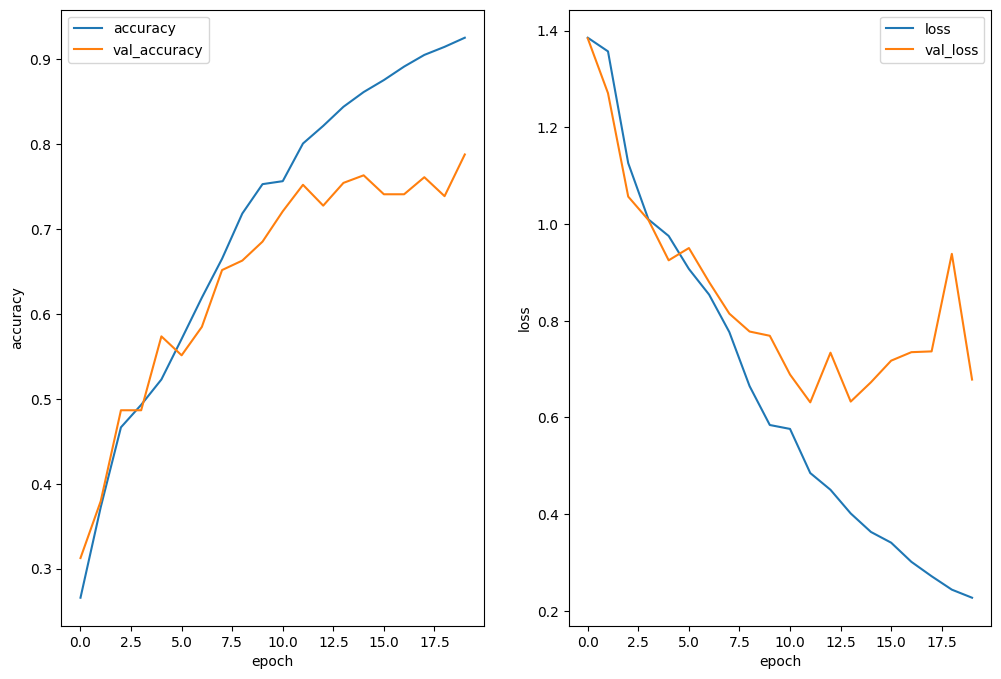

In [38]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

In [43]:
classes = np.argmax(model.predict(["let x =",
                                   "def place_piece(board, x, y, player):",
                                   "void main(string[] args)",
                                   "private vector3 p_pos = new vector3(0, 0, 0);"],
                                         verbose=0), axis=-1)
predictions = [class_names[class_] for class_ in classes]
print(predictions)

['javascript', 'python', 'java', 'csharp']
